# Data

---



---


- (part-00000-d43eef32-dc2e-43f2-be6a-76fcb89370c4-c000.csv) are Created from the notebook called (prepare_data_thirdparty_) in the folder called Data_third_party

- (part-00000-31cb3ff6-ed56-4ab9-8745-918bf546cde2-c000.csv and part-00001-31cb3ff6-ed56-4ab9-8745-918bf546cde2-c000.csv) are Created from the notebook called (Scrapping_twitter_data_andprepare) exists in the folder called  data_scarping

# Libraries

---



---



In [1]:
!pip install spark 
!pip install findspark 
!pip install pyspark
!pip install textblob

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import findspark
findspark.init()
import pyspark as ps
import warnings
from pyspark.sql import SQLContext
from pyspark.sql.types import DoubleType
from pyspark.ml import Pipeline
import numpy
from numpy import allclose
from pyspark.ml.linalg import Vectors
import spark
from pyspark.ml.feature import StopWordsRemover
from pyspark.ml.feature import Tokenizer, RegexTokenizer
from pyspark.sql.functions import col, udf
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import regexp_replace
from pyspark.ml.feature import ChiSqSelector
import pandas as pd
import numpy as np
from pyspark.sql import *
from pyspark.ml.feature import Tokenizer, RegexTokenizer,StopWordsRemover, CountVectorizer ,OneHotEncoder, StringIndexer, VectorAssembler, HashingTF, IDF
from pyspark.sql.functions import col, udf
import matplotlib.pyplot as plt
from pyspark.sql.types import *
from pyspark.ml.linalg import Vectors, VectorUDT
from pyspark.sql.functions import *
from pyspark.ml.classification import LogisticRegression, OneVsRest ,  NaiveBayes ,LinearSVC
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics
from sklearn.metrics import roc_curve
from pyspark.ml.linalg import Vectors
from pyspark.ml.functions import vector_to_array
from pyspark.mllib.linalg import Vectors as OldVectors
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay
from wordcloud import WordCloud, STOPWORDS

# Read Data

---



---



In [3]:
try:
    # create SparkContext on all CPUs available: in my case I have 4 CPUs on my laptop
    sc = ps.SparkContext('local[4]')
    sqlContext = SQLContext(sc)
    print("Just created a SparkContext")
except ValueError:
    warnings.warn("SparkContext already exists in this scope")
print(sc.master)
df_twitter = sqlContext.read.format('com.databricks.spark.csv').options(header='true', inferschema='true').load('/content/part-00000-d43eef32-dc2e-43f2-be6a-76fcb89370c4-c000.csv')    
df_twitter_scrape = sqlContext.read.format('com.databricks.spark.csv').options(header='true', inferschema='true').load('/content/part-00000-31cb3ff6-ed56-4ab9-8745-918bf546cde2-c000.csv')  
df_twitter_scrape2 = sqlContext.read.format('com.databricks.spark.csv').options(header='true', inferschema='true').load('/content/part-00001-31cb3ff6-ed56-4ab9-8745-918bf546cde2-c000.csv')  

/usr/local/lib/python3.8/dist-packages/pyspark/sql/context.py:112: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


Just created a SparkContext
local[4]


# Merging  Data

---



---



In [4]:
cols = ['label', 'tweet']    
df_twitter_ = df_twitter.select(cols)
print("Count of third_party data" , df_twitter_.count())
df_scrapping = df_twitter_scrape.union(df_twitter_scrape2)
print("Count of scraped data" , df_scrapping.count())
data_twitter_merge = df_scrapping.union(df_twitter_)
print("Count of data After merging 2 datasets " , data_twitter_merge.count())
data_twitter_merge.show(5)


Count of third_party data 29528
Count of scraped data 23003
Count of data After merging 2 datasets  52531
+-----+--------------------+
|label|               tweet|
+-----+--------------------+
|  1.0|@cz_binance 🔹 Ma...|
|  1.0|As a layman, the ...|
|  0.0|📣MAIN2022 call f...|
|  0.0|I think @DavidAMa...|
|  1.0|@gershbrain We ke...|
+-----+--------------------+
only showing top 5 rows



#Check null and duplicated values

---



---



In [5]:
print("count of  merged data  "  ,  data_twitter_merge.count())
print("count of null values in merged data " , data_twitter_merge.filter(data_twitter_merge.tweet.isNull()).count())
data_twitter_merge = data_twitter_merge.dropna()
print("count of null values in merged data after droping null " , data_twitter_merge.count())

count of  merged data   52531
count of null values in merged data  1
count of null values in merged data after droping null  52530


In [6]:
# To remove the duplicates:
print("count of  merged data  "  ,  data_twitter_merge.count())
print("count of Distinct values in merged data " , data_twitter_merge.distinct().count())
data_twitter_merge = data_twitter_merge.dropDuplicates()
print("count of merged data after drop duplications " , data_twitter_merge.count())# there is no duplicated

count of  merged data   52530
count of Distinct values in merged data  52450
count of merged data after drop duplications  52450


#Check imbalance 

---



---



The Number of instances in class 0 (Neg_class)  38255
The Number of instances in class 1 (Pos_class)  10946
The Number of instances in class 2 (Neutral_class)  3249


<BarContainer object of 3 artists>

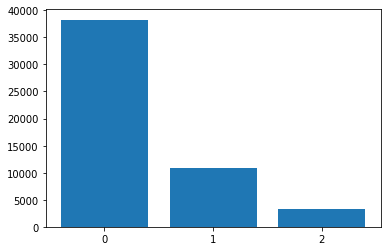

In [7]:
print("The Number of instances in class 0 (Neg_class) ", data_twitter_merge.filter(data_twitter_merge.label == 0).count())
print("The Number of instances in class 1 (Pos_class) ", data_twitter_merge.filter(data_twitter_merge.label == 1).count())
print("The Number of instances in class 2 (Neutral_class) ", data_twitter_merge.filter(data_twitter_merge.label == 2).count())
plt.bar(['0' , '1' , '2'] , [data_twitter_merge.filter(data_twitter_merge.label == 0).count(), data_twitter_merge.filter(data_twitter_merge.label == 1).count() , data_twitter_merge.filter(data_twitter_merge.label == 2).count()])


## Solve imbalance using oversampling 

---



---



In [8]:
minor_pos_class = data_twitter_merge.filter(data_twitter_merge.label == 1)
major_neg_class = data_twitter_merge.filter(data_twitter_merge.label == 0)
minor_neutral_class = data_twitter_merge.filter(data_twitter_merge.label == 2)


ratio_pos_class = int(major_neg_class.count()/minor_pos_class.count())
ratio_neutral_class = int(major_neg_class.count()/minor_neutral_class.count())

ratio_pos_class_ = range(ratio_pos_class)
ratio_neutral_class_ = range(ratio_neutral_class)

# duplicate the minority rows
oversampled_pos_class = minor_pos_class.withColumn("dummy", explode(array([lit(x) for x in ratio_pos_class_]))).drop('dummy')
oversampled_neutral_class = minor_neutral_class.withColumn("dummy", explode(array([lit(x) for x in ratio_neutral_class_]))).drop('dummy')

# combine both oversampled minority rows and previous majority rows
combined_class_neutral_pos = oversampled_pos_class.unionAll(oversampled_neutral_class)
combined_data = combined_class_neutral_pos.unionAll(major_neg_class)
print("Count data after applying oversampling" ,  combined_data.count())
combined_data.show()

Count data after applying oversampling 106832
+-----+--------------------+
|label|               tweet|
+-----+--------------------+
|  1.0|@BennieMols @hara...|
|  1.0|@BennieMols @hara...|
|  1.0|@BennieMols @hara...|
|  1.0|If a computer bec...|
|  1.0|If a computer bec...|
|  1.0|If a computer bec...|
|  1.0|Listen to Kyle Du...|
|  1.0|Listen to Kyle Du...|
|  1.0|Listen to Kyle Du...|
|  1.0|@MatrixAINetwork ...|
|  1.0|@MatrixAINetwork ...|
|  1.0|@MatrixAINetwork ...|
|  1.0|Getting old but s...|
|  1.0|Getting old but s...|
|  1.0|Getting old but s...|
|  1.0|What's the latest...|
|  1.0|What's the latest...|
|  1.0|What's the latest...|
|  1.0|@itnEditor The Ce...|
|  1.0|@itnEditor The Ce...|
+-----+--------------------+
only showing top 20 rows



# Visualize data After applying oversampling 

---



---



The Number of instances in class 0 (Neg_class) After applying oversampling  38255
The Number of instances in class 1 (Pos_class) After applying oversampling  32838
The Number of instances in class 2 (Neutral_class) After applying oversampling 35739


<BarContainer object of 3 artists>

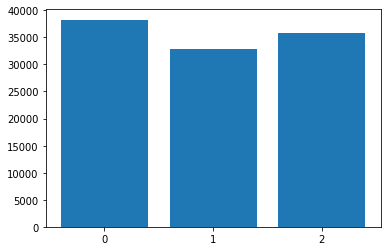

In [9]:
print("The Number of instances in class 0 (Neg_class) After applying oversampling ", combined_data.filter(combined_data.label == 0).count())
print("The Number of instances in class 1 (Pos_class) After applying oversampling ", combined_data.filter(combined_data.label == 1).count())
print("The Number of instances in class 2 (Neutral_class) After applying oversampling", combined_data.filter(combined_data.label == 2).count())
plt.bar(['0' , '1' , '2'] , [combined_data.filter(combined_data.label == 0).count(), combined_data.filter(combined_data.label == 1).count() , combined_data.filter(combined_data.label== 2).count()])

# StopWord removing 

---



In [10]:
combined_data.show()

+-----+--------------------+
|label|               tweet|
+-----+--------------------+
|  1.0|@BennieMols @hara...|
|  1.0|@BennieMols @hara...|
|  1.0|@BennieMols @hara...|
|  1.0|If a computer bec...|
|  1.0|If a computer bec...|
|  1.0|If a computer bec...|
|  1.0|Listen to Kyle Du...|
|  1.0|Listen to Kyle Du...|
|  1.0|Listen to Kyle Du...|
|  1.0|@MatrixAINetwork ...|
|  1.0|@MatrixAINetwork ...|
|  1.0|@MatrixAINetwork ...|
|  1.0|Getting old but s...|
|  1.0|Getting old but s...|
|  1.0|Getting old but s...|
|  1.0|What's the latest...|
|  1.0|What's the latest...|
|  1.0|What's the latest...|
|  1.0|@itnEditor The Ce...|
|  1.0|@itnEditor The Ce...|
+-----+--------------------+
only showing top 20 rows



In [11]:
combined_data.select("tweet").show(truncate=False)

+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|tweet                                                                                                                                                                                                                                                                                                                         |
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|@BennieMols @harari_yuval @rodneyabr

In [12]:
number = r'[0-9]'
url = 'https?://[^ ]+'
regex_url_numbers_ = r'|'.join((url, number))

df_pattern_removed = combined_data.select(regexp_replace('tweet', regex_url_numbers_ , ' ').alias('pattern_replaced'), "label")
# # # tokenize tweet and remove any special charcters (# , @ , " , ')
regexTokenizer = RegexTokenizer(inputCol="pattern_replaced", outputCol="Tweet_words"  , pattern= '\\W')
countTokens = udf(lambda words: len(words), IntegerType())
regexTokenized = regexTokenizer.transform(df_pattern_removed)
regexTokenized.select( "Tweet_words" ).show(truncate=False)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|Tweet_words                                                                                                                                                                                                                                                                                                                                                          |
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [13]:
remover = StopWordsRemover( inputCol="Tweet_words", outputCol="Tweet_without_stopword") # lower all charchter
tweets_distinct_remove_stopwords = remover.transform(regexTokenized)
tweets_distinct_remove_stopwords.select("Tweet_without_stopword").show(truncate=False)

+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|Tweet_without_stopword                                                                                                                                                                                                                                                  |
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|[benniemols, harari_yuval, rodneyabrooks, guess, agree, disagree, across, board, progress, steady, relentless, consistently, higher, rate, envisioned, given, progress, cog, neuroscience, ai, within,

In [14]:
clean_data = tweets_distinct_remove_stopwords.select("Tweet_without_stopword" , "label")
clean_data.filter(clean_data.Tweet_without_stopword.isNull()).count()


0

# Visualize 5 words that have highest frequency in our data 

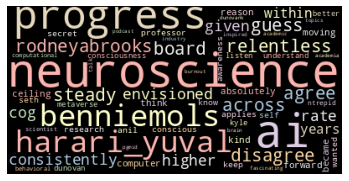

In [15]:
from wordcloud import WordCloud, STOPWORDS
word_common_df =clean_data.withColumn('word', explode( clean_data.Tweet_without_stopword))
sqlContext.registerDataFrameAsTable(word_common_df, "wordcloud")
df_cloud = sqlContext.sql("Select * from wordcloud limit 200")
df_cloud =df_cloud.toPandas()
text = " ".join(w for w in df_cloud.word)
#  Generate word cloud
word_cloud = WordCloud(width=400,height=200,random_state=1,background_color="black",colormap="Pastel1",collocations=False).generate(text)
plt.imshow(word_cloud)
plt.axis("off")
plt.show()

<AxesSubplot:xlabel='word'>

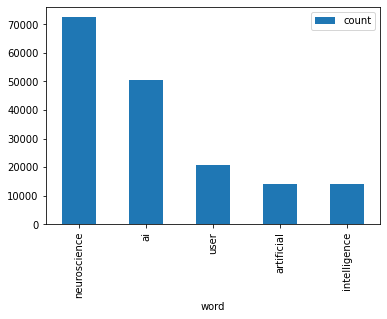

In [16]:
word_count = clean_data.withColumn('word', explode( clean_data.Tweet_without_stopword)).groupby('word').count()
sqlContext.registerDataFrameAsTable(word_count, "word_count")
df = sqlContext.sql("Select * from word_count ORDER BY word_count.count DESC limit 5")
df = df.toPandas()
df.set_index('word').plot.bar()

In [17]:
print("sample of word and its count" , word_count.show())

+--------------+-----+
|          word|count|
+--------------+-----+
|    creativity|  274|
|         still|  984|
|         cures|   18|
|     standards|   24|
|      currents|    3|
|  erc_research|    4|
|      incoming|   10|
|          hope|  643|
|cheeseforevery|    3|
|   interaction|  247|
|    electrical|  107|
|           art|  444|
|    gershbrain|   63|
|     umontreal|   43|
|    indigenous|   23|
|           ces|   63|
|        online|  495|
|          earl|    8|
|     connected|  129|
|         inner|   85|
+--------------+-----+
only showing top 20 rows

sample of word and its count None


<AxesSubplot:xlabel='Tweet_without_stopword'>

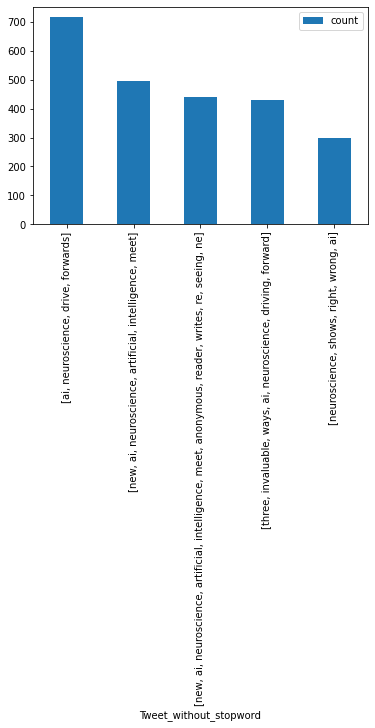

In [18]:
most_freq_tweet = clean_data.groupBy("Tweet_without_stopword").count().orderBy(col("count").desc())
sqlContext.registerDataFrameAsTable(most_freq_tweet, "most_freq_tweet")
df_most_freq_tweet = sqlContext.sql("Select * from most_freq_tweet limit 5")
df_most_freq_tweet  = df_most_freq_tweet.toPandas()
df_most_freq_tweet.set_index('Tweet_without_stopword').plot.bar()

# Split data 

---



In [19]:
(train_set, test_set) = clean_data.randomSplit([0.90, 0.1], seed = 2000)
print(train_set.show(50))
print(test_set.show())

+----------------------+-----+
|Tweet_without_stopword|label|
+----------------------+-----+
|                    []|  1.0|
|                    []|  1.0|
|                    []|  1.0|
|                    []|  1.0|
|                    []|  1.0|
|                    []|  1.0|
|                    []|  1.0|
|                    []|  1.0|
|                    []|  1.0|
|  [__rej__, think, ...|  1.0|
|  [__rej__, think, ...|  1.0|
|  [__rej__, think, ...|  1.0|
|  [_deame, kelly_mc...|  1.0|
|  [_deame, kelly_mc...|  1.0|
|  [_humblebeast_, e...|  1.0|
|  [_humblebeast_, e...|  1.0|
|  [_kriesz_, monstr...|  1.0|
|  [_kriesz_, monstr...|  1.0|
|  [_kriesz_, monstr...|  1.0|
|  [_lost_letters_, ...|  1.0|
|  [_lost_letters_, ...|  1.0|
|  [_rdgao, naturehu...|  1.0|
|  [_rdgao, naturehu...|  1.0|
|  [_rdgao, naturehu...|  1.0|
|  [_thegeoff, fimus...|  1.0|
|  [_thegeoff, fimus...|  1.0|
|  [_thegeoff, fimus...|  1.0|
|  [a_darkhorse_, ru...|  1.0|
|  [a_darkhorse_, ru...|  1.0|
|  [a_da

# More Preprocessing

In [20]:
def Vectorize_features(name_input_col, name_out_col , train_data , test_data):
    hashtf = HashingTF(numFeatures=2**18, inputCol=name_input_col, outputCol='tf')
    idf = IDF(inputCol='tf', outputCol="features", minDocFreq=5) #minDocFreq: remove sparse terms
    selector = ChiSqSelector(numTopFeatures=2**10,featuresCol='features', outputCol="features_selected")
    label_stringIdx = StringIndexer(inputCol = name_out_col, outputCol = "sentiment")    
    pipeline = Pipeline(stages=[ hashtf, idf, label_stringIdx  , selector])
    pipelineFit = pipeline.fit(train_data)
    train_new = pipelineFit.transform(train_data)
    test_new = pipelineFit.transform(test_data)
    return train_new , test_new

In [21]:
train_df , test_df = Vectorize_features("Tweet_without_stopword" , "label" ,train_set, test_set  )
train_df.show()

+----------------------+-----+--------------------+--------------------+---------+--------------------+
|Tweet_without_stopword|label|                  tf|            features|sentiment|   features_selected|
+----------------------+-----+--------------------+--------------------+---------+--------------------+
|                    []|  1.0|      (262144,[],[])|      (262144,[],[])|      2.0|        (1024,[],[])|
|                    []|  1.0|      (262144,[],[])|      (262144,[],[])|      2.0|        (1024,[],[])|
|                    []|  1.0|      (262144,[],[])|      (262144,[],[])|      2.0|        (1024,[],[])|
|                    []|  1.0|      (262144,[],[])|      (262144,[],[])|      2.0|        (1024,[],[])|
|                    []|  1.0|      (262144,[],[])|      (262144,[],[])|      2.0|        (1024,[],[])|
|                    []|  1.0|      (262144,[],[])|      (262144,[],[])|      2.0|        (1024,[],[])|
|                    []|  1.0|      (262144,[],[])|      (262144

# Helper Function

---



In [22]:

def train_Evaluate_model(train_data,test_data ,model , model_name):
    #----------------Train model ^_^---------------------
    Model = model.fit(train_data)
    #-----------------Test Model -------------------
    predictions = Model.transform(test_data)
    train_pre = Model.transform(train_data)
    print(model_name)
    print("sample of our prediction" )
    print(predictions.show(5))
    print("__"*30)
    #-----------------Evaluate Model -------------------
    evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
    f1score_ = evaluator.evaluate(predictions)
    print('evaluator.getMetricName(): ' , evaluator.getMetricName() ," = ", f1score_)
    print("__"*30)
    train_accuracy = evaluator.evaluate( train_pre , {evaluator.metricName: "accuracy"})
    print('train accuracy = ' ,train_accuracy)
    accuracy = evaluator.evaluate(predictions , {evaluator.metricName: "accuracy"})
    print('test accuracy = ' ,accuracy)
    print("__"*30)
    precision = evaluator.evaluate(predictions , {evaluator.metricName: "weightedPrecision"})
    print('precision = ' ,precision)
    print("__"*30)
    recall = evaluator.evaluate(predictions , {evaluator.metricName: "weightedRecall"})
    print('recall = ' ,recall)
    print("__"*30)
    return predictions, f1score_ , accuracy , precision , recall 

def Visualize_evalution_matrices(predictions ,model , model_name):
    if (model_name == "SVM"):
      y_score_prob = predictions.select(vector_to_array("rawPrediction")[1]).rdd.keys().collect()
    else:
      y_score_prob = predictions.select(vector_to_array("probability")[1]).rdd.keys().collect()
    y_true = predictions.select("label").rdd.keys().collect()


    #--------------------------------Roc Curve  ^_^ ----------------------
    fpr, tpr, thresholds = roc_curve(y_true, y_score_prob,pos_label=1)
    roc_auc = auc(fpr, tpr)
    RocCurveDisplay(fpr = fpr, tpr = tpr, roc_auc = roc_auc, estimator_name = model.__class__.__name__).plot()
    plt.title('ROC/AUC')
    plt.show()

    #--------------------------------recall_percision ^_^ ----------------------
    precision, recall, _ = precision_recall_curve(y_true ,y_score_prob,pos_label=1)
    PrecisionRecallDisplay(precision = precision, recall = recall).plot()
    plt.title('Precision Vs Recall')
    plt.show()  

 
def Confusion_matrix(predictions):
    predictionAndLabels = predictions.select(col("label"), col("prediction"))
    metrics = MulticlassMetrics(predictionAndLabels.rdd.map(lambda x: tuple(map(float, x))))
    confusion_matrix = metrics.confusionMatrix().toArray()
    labels = [int(l) for l in metrics.call('labels')]
    confusion_matrix_df = pd.DataFrame(confusion_matrix , index=labels, columns=labels)
    return confusion_matrix_df , confusion_matrix

def plot_confusionMatrix(Matrix):
    fig, ax = plt.subplots(figsize=(7.5, 7.5))
    ax.matshow(Matrix, cmap=plt.cm.Blues, alpha=0.3)
    for i in range(Matrix.shape[0]):
        for j in range(Matrix.shape[1]):
            ax.text(x=j, y=i,s=Matrix[i, j], va='center', ha='center', size='xx-large')

    plt.xlabel('Predictions', fontsize=18)
    plt.ylabel('Actuals', fontsize=18)
    plt.title('Confusion Matrix', fontsize=18)
    plt.show()

# Build Models & Train Models & Evaluate Models & Visualize 

---



---



## Build Models 

In [23]:
lr = LogisticRegression(maxIter=10)  
nb = NaiveBayes(smoothing=1.0, modelType="multinomial")
lsvc = LinearSVC(maxIter=20, regParam=0.01)
# instantiate the One Vs Rest Classifier.
ovr = OneVsRest(classifier=lsvc)
models_list = [lr , nb ,  ovr ]
models_name = ["Logistic Regression" , "Naive Bayes" , "SVM"]

## Train Models &Evaluate Models & Visualize 

Logistic Regression
sample of our prediction
+----------------------+-----+--------------------+--------------------+---------+--------------------+--------------------+--------------------+----------+
|Tweet_without_stopword|label|                  tf|            features|sentiment|   features_selected|       rawPrediction|         probability|prediction|
+----------------------+-----+--------------------+--------------------+---------+--------------------+--------------------+--------------------+----------+
|  [_deame, kelly_mc...|  1.0|(262144,[10583,23...|(262144,[10583,23...|      2.0|(1024,[252,379,56...|[1.48060201636931...|[0.00151781841985...|       1.0|
|  [_humblebeast_, e...|  1.0|(262144,[7453,640...|(262144,[7453,640...|      2.0|(1024,[32,452,631...|[0.77537008404962...|[0.00766723704059...|       1.0|
|  [_lost_letters_, ...|  1.0|(262144,[54961,10...|(262144,[54961,10...|      2.0|(1024,[526,631,82...|[-3.2972460018194...|[2.43951870480199...|       1.0|
|  [aaryamanv

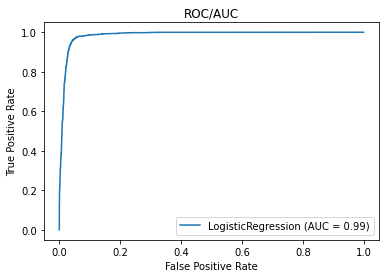

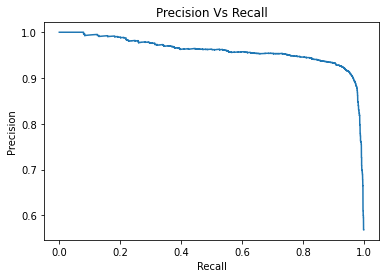

/usr/local/lib/python3.8/dist-packages/pyspark/sql/context.py:157: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


Confusion_matrix of Logistic Regression
        0       1       2
0  3337.0   129.0     7.0
1   324.0  3161.0     0.0
2    70.0     6.0  3559.0


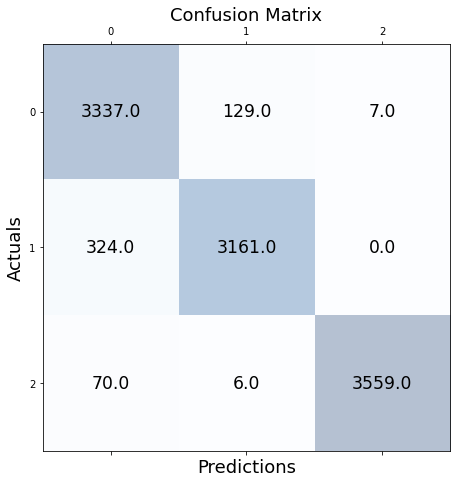

Naive Bayes
sample of our prediction
+----------------------+-----+--------------------+--------------------+---------+--------------------+--------------------+--------------------+----------+
|Tweet_without_stopword|label|                  tf|            features|sentiment|   features_selected|       rawPrediction|         probability|prediction|
+----------------------+-----+--------------------+--------------------+---------+--------------------+--------------------+--------------------+----------+
|  [_deame, kelly_mc...|  1.0|(262144,[10583,23...|(262144,[10583,23...|      2.0|(1024,[252,379,56...|[-785.01686184460...|[3.83424356715808...|       1.0|
|  [_humblebeast_, e...|  1.0|(262144,[7453,640...|(262144,[7453,640...|      2.0|(1024,[32,452,631...|[-628.68297392467...|[1.61567475966700...|       1.0|
|  [_lost_letters_, ...|  1.0|(262144,[54961,10...|(262144,[54961,10...|      2.0|(1024,[526,631,82...|[-375.32467896903...|[2.49268680053646...|       2.0|
|  [aaryamanvir, jos.

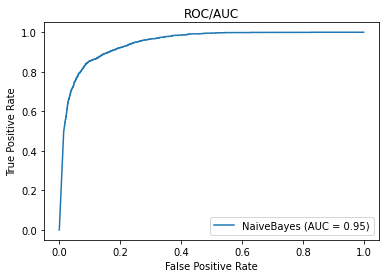

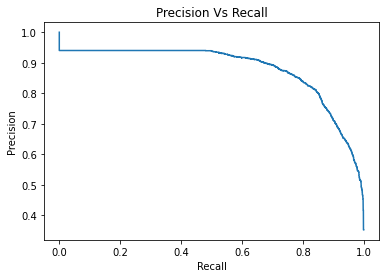

/usr/local/lib/python3.8/dist-packages/pyspark/sql/context.py:157: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


Confusion_matrix of Naive Bayes
        0       1       2
0  2778.0   330.0    39.0
1   663.0  2825.0   111.0
2   290.0   141.0  3416.0


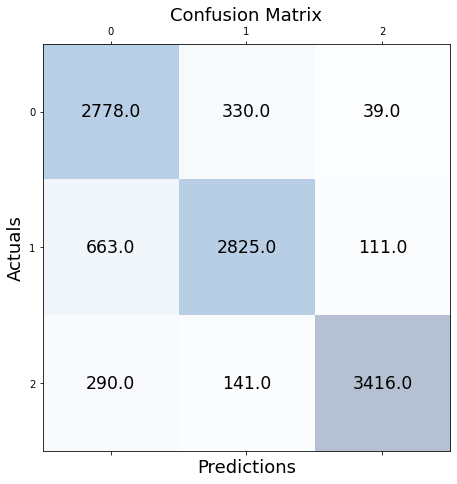

SVM
sample of our prediction
+----------------------+-----+--------------------+--------------------+---------+--------------------+--------------------+----------+
|Tweet_without_stopword|label|                  tf|            features|sentiment|   features_selected|       rawPrediction|prediction|
+----------------------+-----+--------------------+--------------------+---------+--------------------+--------------------+----------+
|  [_deame, kelly_mc...|  1.0|(262144,[10583,23...|(262144,[10583,23...|      2.0|(1024,[252,379,56...|[-1.1878124250534...|       1.0|
|  [_humblebeast_, e...|  1.0|(262144,[7453,640...|(262144,[7453,640...|      2.0|(1024,[32,452,631...|[-1.0455770027557...|       1.0|
|  [_lost_letters_, ...|  1.0|(262144,[54961,10...|(262144,[54961,10...|      2.0|(1024,[526,631,82...|[-2.0048620420613...|       1.0|
|  [aaryamanvir, jos...|  1.0|(262144,[17990,22...|(262144,[17990,22...|      2.0|(1024,[80,146,292...|[-3.0149753458799...|       1.0|
|  [abebab, m, effe

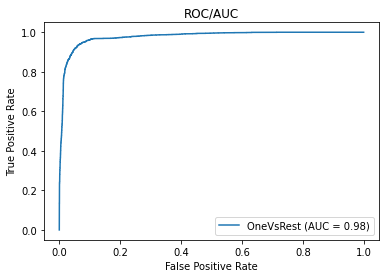

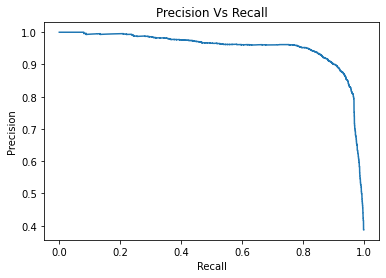

/usr/local/lib/python3.8/dist-packages/pyspark/sql/context.py:157: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


Confusion_matrix of SVM
        0       1       2
0  3383.0   249.0    20.0
1   287.0  3018.0     1.0
2    61.0    29.0  3545.0


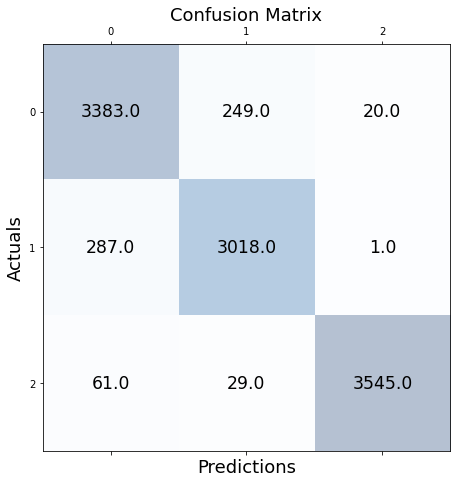

In [24]:
for i in range(len(models_list)):
  predictions, f1score_ , accuracy , precision , recall = train_Evaluate_model(train_df,test_df ,models_list[i] , models_name[i])
  Visualize_evalution_matrices(predictions , models_list[i],models_name[i])
  cm_dataframe , cm_matrix = Confusion_matrix(predictions)
  print("Confusion_matrix of {}".format(models_name[i]))
  print(cm_dataframe)
  plot_confusionMatrix(cm_matrix)
